In [1]:
import numpy as np

In [2]:
class Sequential:
  """
    This class contains multiple layers in sequence
  """
  def __init__(self, layers, learning_rate):
    self.layers = layers # layers of this model
    self.lr = learning_rate # learning rate

  def forward_pass(self, inputs):
    """
      forward passing to the whole network
    """
    outputs = inputs
    for layer in self.layers:
      outputs = layer.forward_pass(outputs)
    return outputs

  def backward_pass(self, derivations):
    """
      backpropagation in the network
    """
    for layer in self.layers[::-1]:
      derivations = layer.backward_pass(derivations)

  def optimize(self):
    """
      optimizing all the parameters in the network
    """
    for layer in self.layers:
      if layer.trainable: # if the layer has trainable parameters
        layer.optimize(self.lr) 

class Dense:
  def __init__(self, num_previous_layer_units, num_units):
    self.trainable = True # if the layers is trainable
    self.units = num_units # number of neurons in this layer
    self.prev_units = num_previous_layer_units # number of neurons in the previous layer
    # weight initialization
    self.weights = np.random.uniform(-1,1,num_previous_layer_units*num_units).reshape((num_previous_layer_units, num_units))
    self.biases = np.random.uniform(-1,1,num_units).reshape((1,num_units))
  def forward_pass(self, inputs):
    """
      forward passing in this linear layer 
    """
    self.last_input = inputs
    return np.dot(inputs, self.weights) + self.biases # O = WX + b
  def backward_pass(self, derivations):
    """
      backpropagation from this layer
    """
    # computing weight derivations
    new_derivations = np.zeros(self.weights.shape) # weight derivations will be stored here
    inputs = np.mean(self.last_input, axis=0)
    for i in range(new_derivations.shape[0]):
      for j in range(new_derivations.shape[1]):
          new_derivations[i,j] = inputs[i] * derivations[j]
    self.derivations = new_derivations
    # computing bias derivations
    bias_derivations = np.zeros(self.biases.shape)
    for i in range(self.units):
      bias_derivations[0,i] = derivations[i]
    self.bias_derivations = bias_derivations
    # compute the derivations for the next layer in backpropagation
    input_derivations = np.zeros(shape=(self.prev_units))
    for i in range(len(input_derivations)):
      input_derivations[i] = np.sum(derivations * self.weights[i])
    return input_derivations
  def optimize(self, learning_rate):
    """
      optimizing the parameters of this linear layer based on last derivations calculated in backpropagation function
    """
    self.weights = self.weights - learning_rate * self.derivations
    self.biases = self.biases - learning_rate * self.bias_derivations

class Sigmoid:
  """
    This is a Sigmoid activation layer
  """
  def __init__(self):
    self.trainable = False # this layer does not have any trainable parameter
  def forward_pass(self, inputs):
    """
      This function applies forward pass for a layer of sigmoid activation function
      inputs: output of previous layer with shape (batch_size, num_prev_layer_units)
    """
    self.last_input = inputs # storing the last input to further use it in backpropagation step
    return self.sigmoid(inputs)

  def backward_pass(self, derivations):
    """
      Backpropagation for this Sigmoid layer
      derivations: this is the derivation of this layer's neurons which was calculated ans passed by previous layer in backward pass
    """
    new_derivations = np.zeros(shape=(self.last_input.shape[1], 1))
    inputs = np.mean(self.last_input, axis=0)
    inputs_sigmoid = self.sigmoid(inputs)
    for i in range(new_derivations.shape[0]):
      new_derivations[i,0] = derivations[i] * inputs_sigmoid[i] * (1 - inputs_sigmoid[i]) # formula for derivation of sigmoid is sigmoid * (1 - sigmoid)
    return new_derivations

  def sigmoid(self, inputs):
    """
      calculating the sigmoid function
      formula is 1 / (1 + e^(-x))
    """
    return 1 / (1 + np.exp(-inputs))

class Tanh:
  def __init__(self):
    self.trainable = False # this layer does not have any trainable parameters
  def forward_pass(self, inputs):
    """
      This function applies forward pass for a layer of tanh activation function
      inputs: output of previous layer with shape (batch_size, num_prev_layer_units)
    """
    self.last_input = inputs
    return self.tanh(inputs)

  def backward_pass(self, derivations):
    """
      Calculates the derivations for next layer in backpropagation process
      derivations: this is the derivation of this layer's neurons which was calculated ans passed by previous layer in backward pass
    """
    new_derivations = np.zeros(shape=(self.last_input.shape[1]))
    inputs = np.mean(self.last_input, axis=0)
    inputs_tanh = self.tanh(inputs)
    for i in range(new_derivations.shape[0]):
      new_derivations[i] = derivations[i] * (1 - inputs_tanh[i] * inputs_tanh[i]) # formula for derivation of tanh is 1 - tanh^2
    return new_derivations

  def tanh(self, inputs):
    """
      calculating the tanh function
    """
    return np.tanh(inputs)



In [3]:
# defining the model using defined classes
model = Sequential(
    [
        Dense(2,8),
        Tanh(),
        Dense(8,4),
        Tanh(),
        Dense(4,1),
        Tanh(),
    ],
    0.01 # learning rate
)
# defining the train set
x_train = np.array([
    [1,1],
    [1,-1],
    [-1,1],
    [-1,-1]
])
# labels
y_train = np.array([1,-1,-1,1])

In [4]:
num_epochs = 1000
losses = []
for i in range(num_epochs):
  avg_loss = 0
  for j in range(4):
    output = model.forward_pass([x_train[j],])
    loss = (y_train[j] - output[0][0]) ** 2
    derivation = (output[0][0] - y_train[j])
    avg_loss += loss
    model.backward_pass(np.array([derivation,]))
    model.optimize()
  avg_loss /= 4
  losses.append(avg_loss)
  if i % 50 == 0:
    print(f"epoch {i}: loss: {avg_loss}")


epoch 0: loss: 1.4457245496940585
epoch 50: loss: 0.5148646034534683
epoch 100: loss: 0.15829494029293553
epoch 150: loss: 0.06402556492133354
epoch 200: loss: 0.03546582429838912
epoch 250: loss: 0.023324982001497848
epoch 300: loss: 0.016943925067009657
epoch 350: loss: 0.01311181831082551
epoch 400: loss: 0.01059477288353692
epoch 450: loss: 0.008832612224242328
epoch 500: loss: 0.007538917697088247
epoch 550: loss: 0.006553690709543981
epoch 600: loss: 0.005781237591529308
epoch 650: loss: 0.005161137598347931
epoch 700: loss: 0.004653524339122707
epoch 750: loss: 0.0042311171215664205
epoch 800: loss: 0.00387466654428798
epoch 850: loss: 0.0035702304739605303
epoch 900: loss: 0.0033074805862786023
epoch 950: loss: 0.003078613961362905


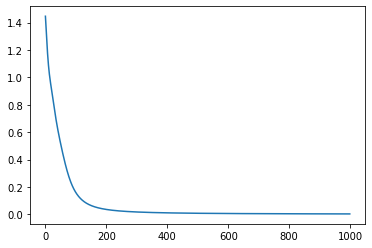

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), losses)

In [6]:
# calculating the accuracy
outputs = model.forward_pass(x_train)
accuracy = 0
for i in range(4):
  if outputs[i] > 0:
    final = 1
  else:
    final = -1
  if y_train[i] == final:
    accuracy += 1
print(f"accuracy = {accuracy / 4}")

accuracy = 1.0
